In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import squidpy as sq
from joblib import Parallel, delayed
from skimage import exposure, io
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

from functools import reduce

import anndata as ad
import scanorama
import seaborn as sns
from matplotlib import cm, colors
from matplotlib.pyplot import rc_context
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import multiprocessing

n_cpu = multiprocessing.cpu_count()

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [4]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

In [31]:
donors = [
    "TS Donor A"
]


# Import data

In [32]:
import matplotlib.patches as mpatches
from skimage.segmentation import mark_boundaries


def get_imgs(file_path, name):
    f = h5py.File(file_path, "r")
    imgs = f[name]
    labels = list(f[name].attrs["labels"])
    return imgs, labels


def contrast_streching(img):
    p2, p98 = np.percentile(img, (0.5, 99.5))
    return exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 1))


# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def read_intensity_per_cell(img, mask):
    props = skimage.measure.regionprops_table(
        mask, img, properties=["label", "mean_intensity"]
    )
    df_prop = pd.DataFrame(props)
    # df_prop["mean_intensity"] = df_prop["mean_intensity"]
    # df_prop.drop("area", axis=1, inplace=True)

    df_prop["mean_intensity"] = np.arcsinh(df_prop[["mean_intensity"]])

    return df_prop

def get_img_subset(imgs, marker):
    imgs_subset = []
    for marker in markers:
        idx = labels.index(marker)
        imgs_subset.append(contrast_streching(imgs[idx]))
    return imgs_subset

In [33]:
markers = [
    "CD38",
    "Vimentin",
    "CD21",
    "BCL6",
    "ICOS1",
    "CD11b",
    'CXCR4',
    "CD11c",
    "FoxP3",
    "CD4",
    "CD138",
    "CXCR5",
    "CD20",
    "CD8",
    "C-Myc",
    "PD1",
    "CD83",
    "Ki67",
    "COL1",
    "CD3",
    "CD27",
    "EZH2",
    "H3K27me3",
]
df_all = []
centroids = []

In [34]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

In [35]:
for donor in donors:
    h5_data = p_dir / "data" / "h5" / f"{donor}.hdf5"
    df = pd.read_csv(data_dir / "metadata" / f"info_{donor}.csv")
    ROIs = df.ROI.unique()
    masks = get_masks(data_dir / "masks" / donor)

    for roi in tqdm(ROIs, total=len(ROIs)):
        if roi not in arrangement[donor].keys():
            continue
        imgs, labels = get_imgs(h5_data, str(roi))
        mask = masks[str(roi)]

        imgs = get_img_subset(imgs, markers)

        df_appended_list = []
        for i, img in enumerate(imgs):
            df_prop = read_intensity_per_cell(img, mask)
            df_prop.columns = ["Cell_label", markers[i]]
            df_appended_list.append(df_prop)

        # Combine dataframe
        df_cell_intensity = reduce(
            lambda left, right: pd.merge(left, right, on=["Cell_label"]),
            df_appended_list,
        )
        df_cell_intensity["ROI"] = roi
        df_cell_intensity["Donor"] = donor
        df_all.append(df_cell_intensity)

        props = skimage.measure.regionprops_table(
            mask, properties=["label", "centroid"]
        )
        rows = props["centroid-0"] + arrangement[donor][roi][0]
        cols = props["centroid-1"] + arrangement[donor][roi][1]
        centroid = np.array(list(zip(cols, rows)))
        centroids.append(centroid)

  0%|          | 0/14 [00:00<?, ?it/s]

In [36]:
df = pd.concat(df_all, ignore_index=True)
df.head()

,Cell_label,CD38,Vimentin,CD21,BCL6,ICOS1,CD11b,CXCR4,CD11c,FoxP3,...,PD1,CD83,Ki67,COL1,CD3,CD27,EZH2,H3K27me3,ROI,Donor
0,1,0.009419,0.138944,0.000722,0.0,0.0,0.0,0.0,0.050807,0.0,...,0.0,0.0,0.173392,0.0,0.0,0.0,0.0,0.149585,1,TS Donor A
1,2,0.000000,0.092845,0.000000,0.0,0.0,0.0,0.0,0.025500,0.0,...,0.0,0.0,0.013505,0.0,0.0,0.0,0.0,0.093663,1,TS Donor A
2,3,0.000000,0.041530,0.000000,0.0,0.0,0.0,0.0,0.014198,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.064486,1,TS Donor A
3,4,0.000000,0.064617,0.001010,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.092219,1,TS Donor A
4,5,0.000000,0.027742,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.031003,1,TS Donor A


In [37]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

scaled_features = StandardScaler().fit_transform(np.arcsinh(df.iloc[:,1:-2].values))
df_scaled = pd.DataFrame(scaled_features, columns = df.iloc[:,1:-2].columns)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\thu71\AppData\Local\Temp/ipykernel_154124/3381560123.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,5))


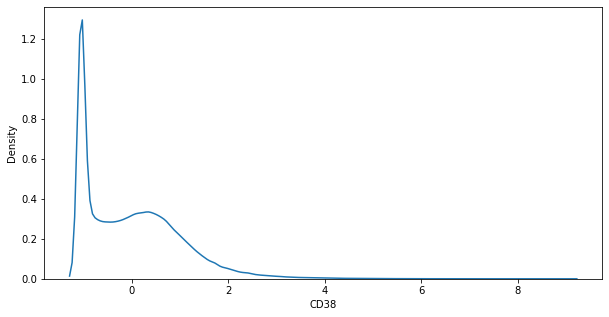

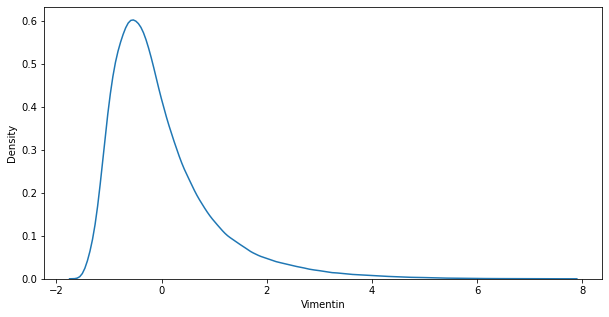

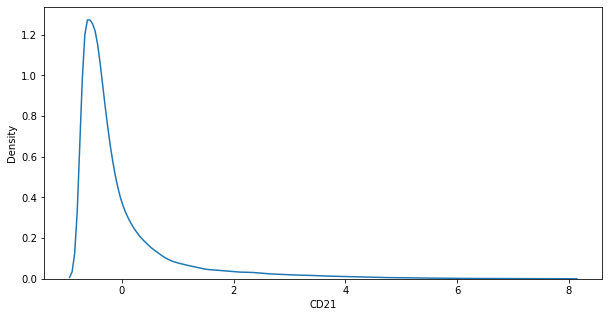

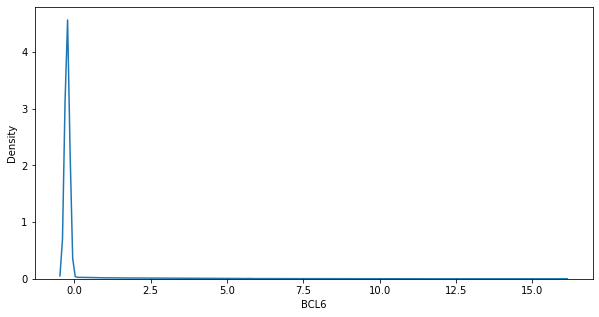

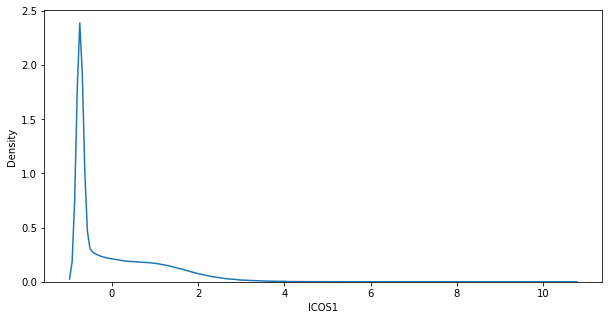

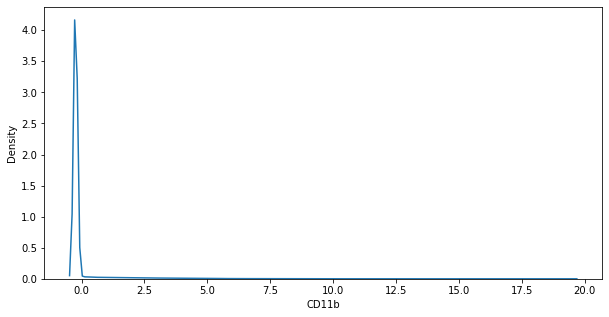

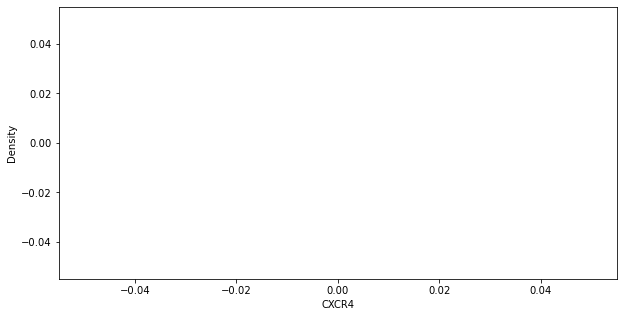

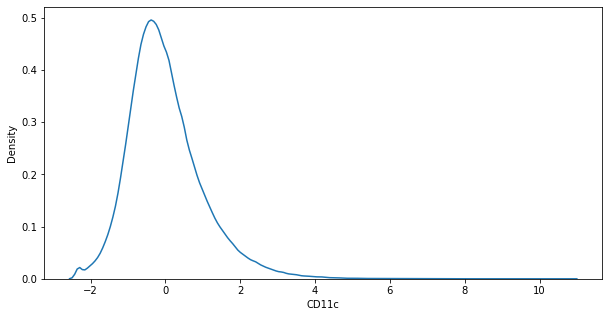

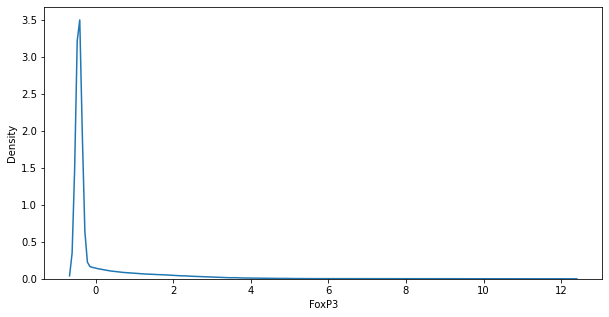

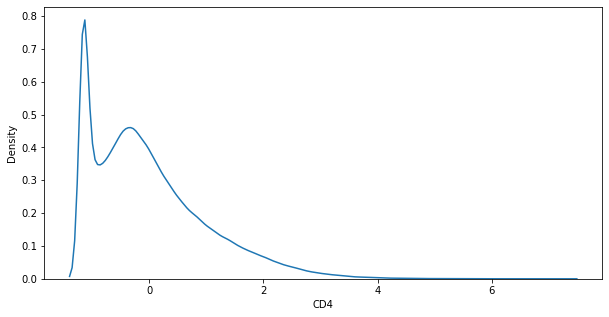

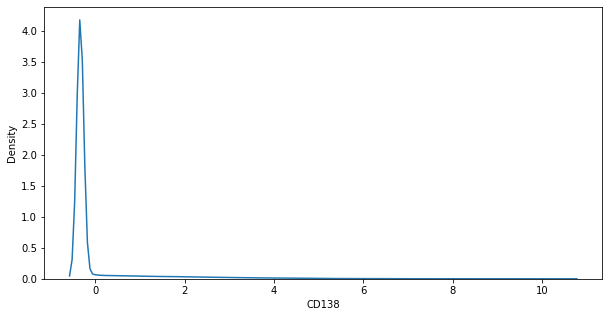

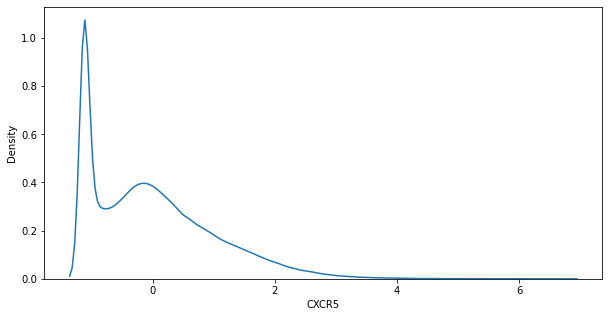

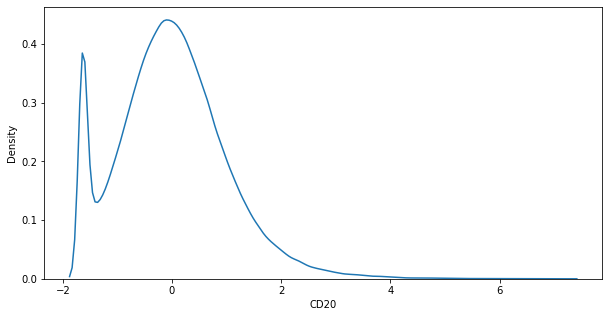

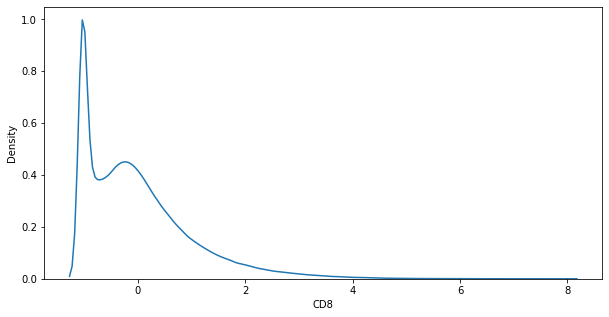

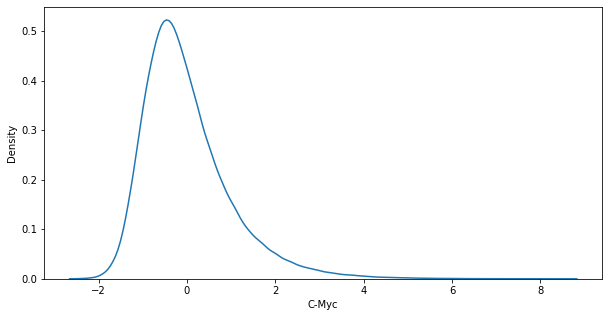

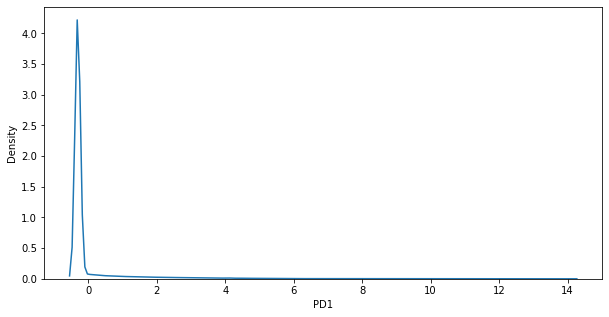

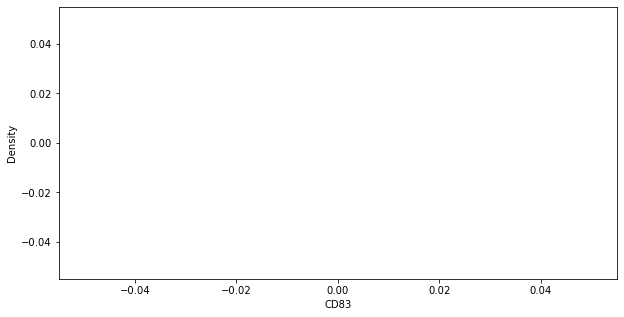

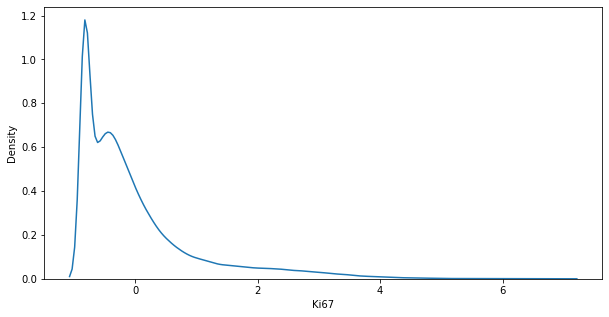

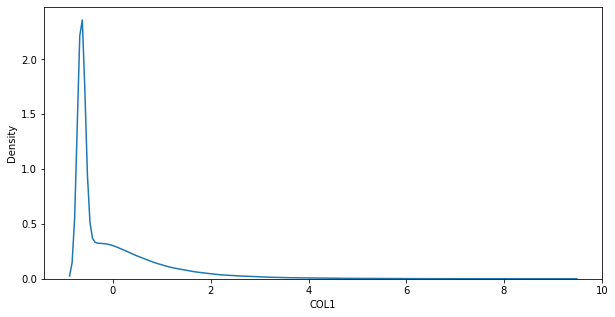

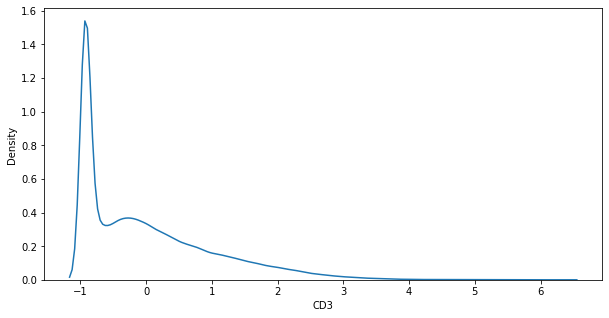

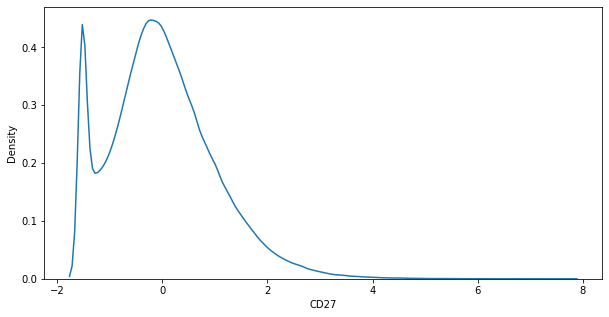

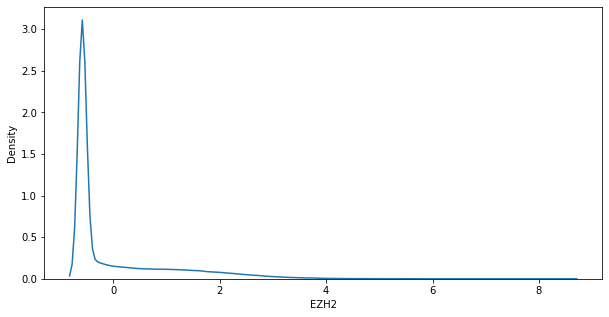

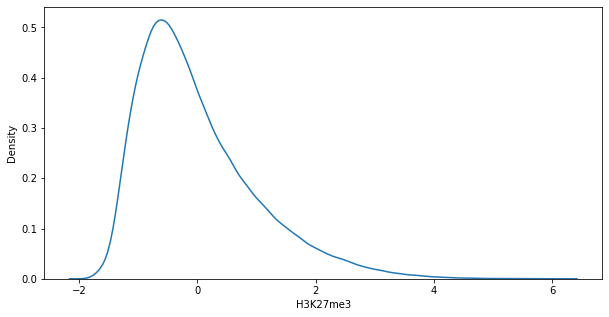

In [39]:
for marker in df_scaled.columns:
    intensities = df_scaled.loc[:, marker]
    fig, ax = plt.subplots(figsize=(10,5))
    sns.kdeplot(intensities, ax=ax)